<h1 align="center"> Automated Text Summarization </h1>

#

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.0 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')

# Access the train split
train_data = dataset['train']
print()
print("Train Sample Data:")
print()
for art,summ in zip(train_data['article'][:5], train_data['highlights'][:5]):
  print("Article:", art)
  print("Summary:",summ)
  print("---")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]


Train Sample Data:

Article: LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK bo

#

## Performing Exploratory Data Analysis.

In [4]:
print("Train Dataset Shape:", train_data.shape)
print()
print("Total No. of Articles:",len(train_data))

Train Dataset Shape: (287113, 3)

Total No. of Articles: 287113


In [5]:
# Explore the distribution of article lengths
article_lengths = [len(article.split()) for article in train_data['article']]
print("Article Word count Statistics:")
print("Min:", min(article_lengths))
print("Max:", max(article_lengths))
print("Avg:", sum(article_lengths) / len(article_lengths))

Article Word count Statistics:
Min: 8
Max: 2347
Avg: 691.8703263175126


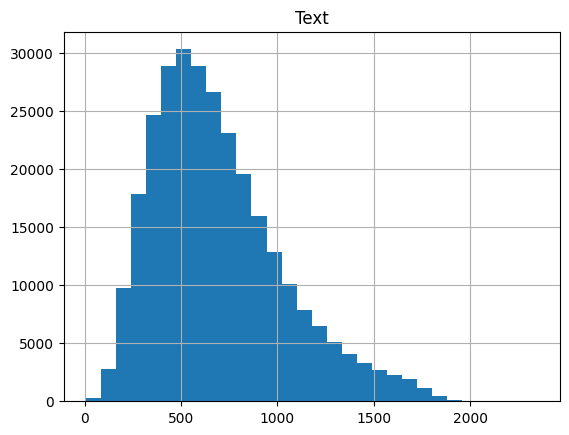

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
length_df = pd.DataFrame({'Text':article_lengths})
length_df.hist(bins = 30)
plt.show()

In [7]:
# Explore the distribution of summary lengths
summary_lengths = [len(summ.split()) for summ in train_data['highlights']]
print("Summary Word count Statistics:")
print("Min:", min(summary_lengths))
print("Max:", max(summary_lengths))
print("Avg:", sum(summary_lengths) / len(summary_lengths))

Summary Word count Statistics:
Min: 4
Max: 1296
Avg: 51.574101486174435


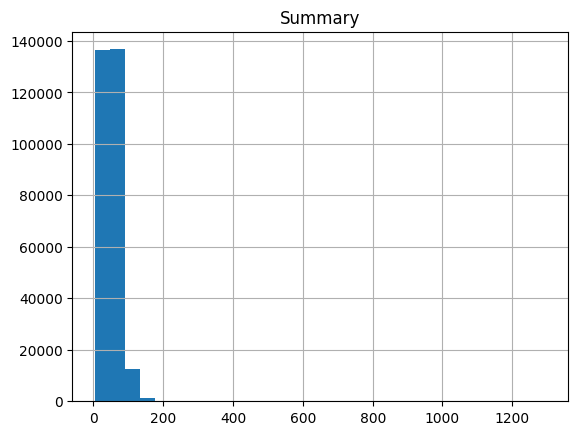

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
length_df = pd.DataFrame({ "Summary":summary_lengths})
length_df.hist(bins = 30)
plt.show()

#

## Data Preprocessing

- As the our article dataset contains around 300K articles, so for fast preprocessing and model building we will use only 20K.

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
                       "'cause": "because", "could've": "could have", "couldn't": "could not",
                          "didn't": "did not", "doesn't": "does not", "don't": "do not",
                       "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is",
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                       "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not",
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have",
                       "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is",
                       "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will",
                       "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is",
                       "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                            "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                            "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have", "you'd": "you would",
                            "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                        "you're": "you are", "you've": "you have"}

In [11]:
import multiprocessing
from tqdm import tqdm

def preprocess_and_clean(text):
     # Remove non-alphanumeric characters
    text = re.sub(r'[^A-Za-z0-9]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Perform Contraction mapping
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and perform lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

def preprocess_dataset(dataset):
    num_cpus = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=num_cpus)

    processed_texts = []
    with tqdm(total=len(dataset), desc="Preprocessing") as pbar:
        for cleaned_text in pool.imap_unordered(preprocess_and_clean, dataset):
            processed_texts.append(cleaned_text)
            pbar.update()

    pool.close()
    pool.join()

    return processed_texts


articles = train_data['article'][0:20000]
highlights = train_data['highlights'][0:20000]

# Preprocess and clean the dataset
cleaned_articles = preprocess_dataset(articles)
cleaned_highlights = preprocess_dataset(highlights)

Preprocessing: 100%|██████████| 20000/20000 [00:20<00:00, 956.58it/s] 


In [12]:
# Print the cleaned dataset
for art,summ in zip(cleaned_articles[0:5],cleaned_highlights[0:5]):
    print('Article:', art)
    print('Highlights:', summ)
    print('---')

Article: editor note behind scene series cnn correspondent share experience covering news analyze story behind event soledad brien take user inside jail many inmate mentally ill inmate housed forgotten floor many mentally ill inmate housed miami trial miami florida cnn ninth floor miami dade pretrial detention facility dubbed forgotten floor inmate severe mental illness incarcerated ready appear court often face drug charge charge assaulting officer charge judge steven leifman say usually avoidable felony say arrest often result confrontation police mentally ill people often told police arrive scene confrontation seems exacerbate illness become paranoid delusional le likely follow direction according leifman end ninth floor severely mentally disturbed getting real help jail toured jail leifman well known miami advocate justice mentally ill even though exactly welcomed open arm guard given permission shoot videotape tour floor go inside forgotten floor first hard determine people prison

#

## Model Building

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00


In [14]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

In [15]:
bart_PATH = 'facebook/bart-large-cnn'
bart_model = BartForConditionalGeneration.from_pretrained(bart_PATH, output_past=True)
bart_tokenizer = BartTokenizer.from_pretrained(bart_PATH)
x = bart_tokenizer(cleaned_articles, truncation=True, max_length=500)

In [39]:
def bart_summarize(input_text, num_beams=4, num_words=80):
    input_text = ' '.join(input_text.split())
    input_tokenized = bart_tokenizer.encode(input_text, return_tensors='pt')
    summary_ids = bart_model.generate(input_tokenized,
                                      num_beams=int(num_beams),
                                      no_repeat_ngram_size=3,
                                      length_penalty=2.0,
                                      min_length=10,
                                      max_length=int(num_words),
                                      early_stopping=True)

    output = [bart_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

    return output[0]

In [18]:
for i in range(5):
  print("Whole Article:",cleaned_articles[i])
  print('Original Summary:',cleaned_highlights[i])
  print("Bart Predicted Summary:", bart_summarize(cleaned_articles[i]))
  print('---')
  print()

Whole Article: editor note behind scene series cnn correspondent share experience covering news analyze story behind event soledad brien take user inside jail many inmate mentally ill inmate housed forgotten floor many mentally ill inmate housed miami trial miami florida cnn ninth floor miami dade pretrial detention facility dubbed forgotten floor inmate severe mental illness incarcerated ready appear court often face drug charge charge assaulting officer charge judge steven leifman say usually avoidable felony say arrest often result confrontation police mentally ill people often told police arrive scene confrontation seems exacerbate illness become paranoid delusional le likely follow direction according leifman end ninth floor severely mentally disturbed getting real help jail toured jail leifman well known miami advocate justice mentally ill even though exactly welcomed open arm guard given permission shoot videotape tour floor go inside forgotten floor first hard determine people 

#

## Model Evaluation - Rouge Score

In [19]:
!pip install rouge-score
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6af0b51d99423019b1a1e7de28092a47c24320d9473338710c3c41c30ee61cb9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from rouge import Rouge

# Define the generated summary and reference summary
generated_summary_bart = '''President bush had his first colonoscopy on Friday.
On Saturday none appeared worrisome. President bush reclaimed presidential power
two hour doctor used monitored anesthesia care. Vice President cheney meanwhile spent morning
home maryland eastern shore reading playing dog. The president played scottish terrier
barney miss beazley after the procedure. He also planned to resume activity camp on Sunday.'''

reference_summary = '''five small polyp found procedure none worrisome spokesman
say president reclaims power transferred vice president bush undergoes routine colonoscopy camp david'''

# Initialize Rouge scorer
rouge_scorer = Rouge()

# Calculate ROUGE scores
rouge_scores = rouge_scorer.get_scores(generated_summary_bart,reference_summary)


# Print the ROUGE scores
print("ROUGE Scores:")
print(f"ROUGE-1 Unigrams: {rouge_scores[0]['rouge-1']}")
print(f"ROUGE-2 Bigrams: {rouge_scores[0]['rouge-2']}")
print(f"ROUGE-L LCS: {rouge_scores[0]['rouge-l']}")

ROUGE Scores:
ROUGE-1 Unigrams: {'r': 0.4, 'p': 0.14814814814814814, 'f': 0.21621621227173124}
ROUGE-2 Bigrams: {'r': 0.0, 'p': 0.0, 'f': 0.0}
ROUGE-L LCS: {'r': 0.3, 'p': 0.1111111111111111, 'f': 0.16216215821767724}



In [41]:
# User define function for Input Article and Generate Summary
def summarize_text(text, num_words):
    # Generate summary using the bart model
    summary = bart_summarize(text, num_words=num_words)
    return summary

# User Input
user_input = input("Enter the text to summarize: ")
# max length of summary
num_words = 35
# Generate Summary
summary = summarize_text(user_input,num_words)

print("Input Text:",user_input)
print()
print("Bart Generated Summary:", summary)

Enter the text to summarize: Since the evolution of humans, devices have been used for calculations for thousands of years. One of the earliest and most well-known devices was an abacus. Then in 1822, the father of computers, Charles Babbage began developing what would be the first mechanical computer. And then in 1833 he actually designed an Analytical Engine which was a general-purpose computer. It contained an ALU, some basic flow chart principles and the concept of integrated memory.  Then more than a century later in the history of computers, we got our first electronic computer for general purpose. It was the ENIAC, which stands for Electronic Numerical Integrator and Computer. The inventors of this computer were John W. Mauchly and J.Presper Eckert.  And with times the technology developed and the computers got smaller and the processing got faster. We got our first laptop in 1981 and it was introduced by Adam Osborne and EPSON.
Input Text: Since the evolution of humans, devices